## import packages

In [1]:
from os import listdir
from os.path import join

from PIL import Image

import numpy as np

import pandas as pd 
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image


## dataset functions

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath)
    return img

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, scale_factor=4):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
        self.tensor = transforms.ToTensor()

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
    
        input = self.tensor(input)
        target = self.tensor(target)
        
        height, width = transforms.functional.get_image_size(input)
        resize = transforms.Resize((int(height/scale_factor), int(width/scale_factor)), 
                                  transforms.InterpolationMode.BICUBIC, 
                                  antialias=True
                                 )
        input = resize(input)
        del(resize)
        
        return input, target
    
    def __len__(self):
        return len(self.image_filenames)


## helper functions

In [3]:
def swap(img):
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    return img


## model

In [4]:
class Model(nn.Module):
    def __init__(self, scale_factor):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 3 * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.clamp(x, 0.0, 1.0)
        x = self.pixel_shuffle(x)
        return x


## train functions

In [5]:
def train(epoch, model):
    epoch_loss = 0
    epoch_loss_history = []
    epoch_test_loss_history = []
    
    for iteration, batch in enumerate(train_dataloader, 1):
        img, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(img), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        if iteration % 5 == 0:
            tbatch = next(iter(test_dataloader))
            timg, ttarget = tbatch[0].to(device), tbatch[1].to(device)
            tloss = criterion(model(timg), ttarget)
            
            epoch_loss_history.append(loss.item())
            epoch_test_loss_history.append(tloss.item())
            
            print("===> Epoch[{}]({}/{}): Loss: {:.6f}, Test Loss: {:.6f}".format(
                epoch+1, iteration, len(train_dataloader), loss.item(), tloss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.6f}".format(epoch+1, epoch_loss / len(train_dataloader)))
    
    return epoch_loss_history, epoch_test_loss_history
    

# $\heartsuit$ main $\heartsuit$

## set device

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
print(device)


cuda


## set hyperparameter

In [7]:
scale_factor    = 4

batch_size      = 32
epoch           = 5
learning_rate   = 0.0003
criterion       = nn.MSELoss()


## create dataloader

In [8]:
train_data = DatasetFromFolder("../../../data/train/wild", scale_factor=scale_factor)
test_data = DatasetFromFolder("../../../data/train/wild", scale_factor=scale_factor)
ref_data = DatasetFromFolder("../../../data/loss", scale_factor=scale_factor)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
ref_dataloader = DataLoader(ref_data, batch_size=1, shuffle=False)


## create model

In [9]:
model = Model(scale_factor=scale_factor).to(device)

## train model

===> Epoch[0](5/149): Loss: 0.133738, Test Loss: 0.100971
===> Epoch[0](10/149): Loss: 0.080069, Test Loss: 0.083569
===> Epoch[0](15/149): Loss: 0.039644, Test Loss: 0.035827
===> Epoch[0](20/149): Loss: 0.036788, Test Loss: 0.034488
===> Epoch[0](25/149): Loss: 0.028929, Test Loss: 0.027757
===> Epoch[0](30/149): Loss: 0.026032, Test Loss: 0.023596
===> Epoch[0](35/149): Loss: 0.024572, Test Loss: 0.020221
===> Epoch[0](40/149): Loss: 0.018884, Test Loss: 0.019122
===> Epoch[0](45/149): Loss: 0.020199, Test Loss: 0.020673
===> Epoch[0](50/149): Loss: 0.013435, Test Loss: 0.013660
===> Epoch[0](55/149): Loss: 0.010678, Test Loss: 0.010739
===> Epoch[0](60/149): Loss: 0.011054, Test Loss: 0.009645
===> Epoch[0](65/149): Loss: 0.010224, Test Loss: 0.009547
===> Epoch[0](70/149): Loss: 0.009382, Test Loss: 0.008274
===> Epoch[0](75/149): Loss: 0.007369, Test Loss: 0.008294
===> Epoch[0](80/149): Loss: 0.006913, Test Loss: 0.007898
===> Epoch[0](85/149): Loss: 0.008439, Test Loss: 0.00740

===> Epoch[4](105/149): Loss: 0.003262, Test Loss: 0.002929
===> Epoch[4](110/149): Loss: 0.002416, Test Loss: 0.002815
===> Epoch[4](115/149): Loss: 0.002713, Test Loss: 0.002634
===> Epoch[4](120/149): Loss: 0.002225, Test Loss: 0.002382
===> Epoch[4](125/149): Loss: 0.003071, Test Loss: 0.003662
===> Epoch[4](130/149): Loss: 0.001638, Test Loss: 0.002512
===> Epoch[4](135/149): Loss: 0.002660, Test Loss: 0.002408
===> Epoch[4](140/149): Loss: 0.002524, Test Loss: 0.002512
===> Epoch[4](145/149): Loss: 0.002376, Test Loss: 0.002666
===> Epoch 4 Complete: Avg. Loss: 0.002757


C:\Users\zhp33\AppData\Local\Temp\ipykernel_17608\2674936986.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


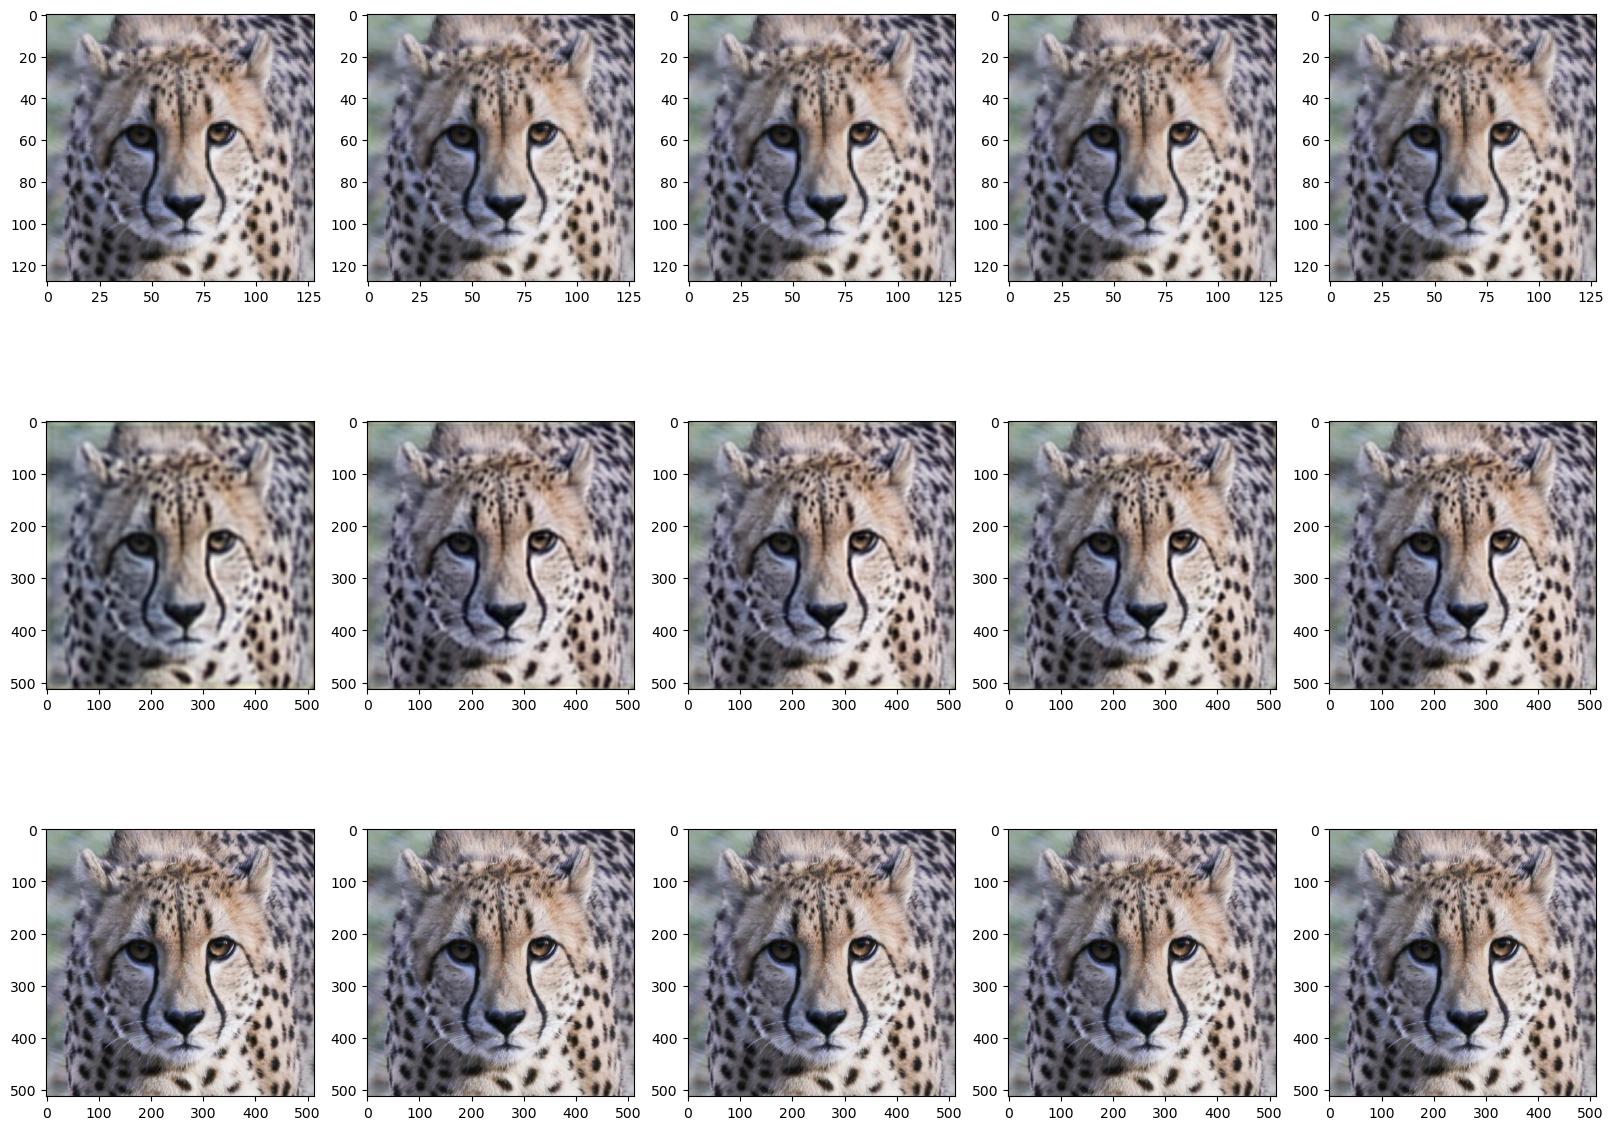

In [10]:
figure, ax = plt.subplots(3, epoch)
figure.set_size_inches(20, 15)

loss_history = []
test_loss_history = []

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epoch):
    epoch_loss_history, epoch_test_loss_history = train(i, model)
    loss_history = loss_history + epoch_loss_history
    test_loss_history = test_loss_history + epoch_test_loss_history
    del(epoch_loss_history)
    del(epoch_test_loss_history)
    
    ref = next(iter(ref_dataloader))[0]
    ref_tgt = next(iter(ref_dataloader))[1]
    ref_fit = model(ref.to(device)).cpu()
    
    ref = swap(ref.squeeze())
    ref_tgt = swap(ref_tgt.squeeze())
    ref_fit = swap(ref_fit.detach().numpy().squeeze())

    ax[0, i].imshow(ref)
    ax[1, i].imshow(ref_fit)
    ax[2, i].imshow(ref_tgt)

figure.show()


## plot loss history

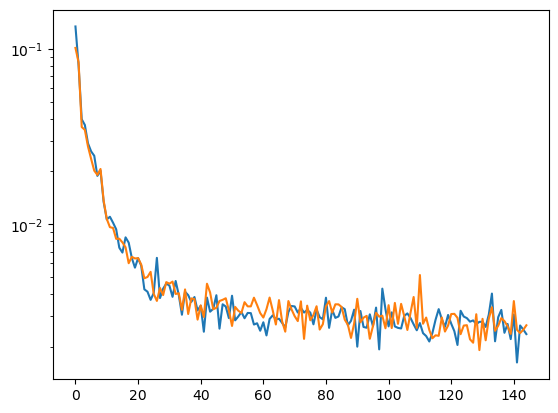

In [11]:
plt.yscale("log")
plt.plot(loss_history)
plt.plot(test_loss_history)
plt.show()


## save model (optional)

In [14]:
torch.save(model.state_dict(), '../../model')

RuntimeError: File ../../model cannot be opened.

## load model (optional)

In [ ]:
model = Model(scale_factor=scale_factor).to(device)
model.load_state_dict(torch.load('../../model/model.pt'))